# Inaugural Project - Housing demand and taxation
### - *Luna Hjerteknuser*
A given household can spend cash $m$ on either housing or consumption $c$. Quality of housing, $h$, grants household utility and has the cost $p_{h}$ which is subject to progressive taxation and morgage cost as by equation (\ref{eq4}). The household aims to maximize utility such that optimal amounts of housing, $h^{*}$, and consumption, $c^{*}$, are met according to equation (\ref{eq1}).

\begin{align}
    c^{*},h^{*} & = \underset{c, h}{\operatorname{argmax}} c^{1-\phi}h^{\phi} \label{eq1}\tag{1} \\
    &s.t.\\
    \tilde{p}_{h} &= p_{h}\varepsilon \label{eq2}\tag{2} \\
    m &= \tau(p_{h},\tilde{p}_{h})+c \label{eq3}\tag{3} \\
    \tau(p_{h},\tilde{p}_{h})&=r p_{h}+\tau^{g}\tilde{p}_{h}+\tau^{p}max\{\tilde{p}_{h}-\bar{p},0\} \label{eq4}\tag{4}
\end{align}

The houses are taxed according to the public assesment being $\tilde{p}_{h}$. The assesment is politically decided according to equation (\ref{eq2}) by $\varepsilon$. Available cash for a given household is split between housing costs and consumption. $r$ denotes the carrying interest for purchasing a home, and $\tau^{g}$ denotes the base housing tax while the last element in equation (\ref{eq4}) homes valued above a certain cutoff, $\bar{p}$ are taxed at an additional rate $\tau^{p}$

# Q1 Construct a function that solves the household's problem above.
We let the market price of a home be equal to its quality: $$ p_{h}=h $$ and assume that the households has cash-on-hand $m=0.5$,and the given parameter-values defined in the assignment. Notice, the monetary units is in millions DKK. 

Knowing the marketprice of a home is equal to its quality, we use a scalar solver using the problems monotonicity. However, we solve it by a vector, that is optimize.minimize()
$$ c = m - \tau(p_{h},\tilde{p}_{h})\Leftrightarrow $$
$$ c = m - rh-\tau^{g}h\varepsilon+\tau^{p}max\{h\varepsilon-\bar{p},0 \}   $$
meaning $c$ is implicit for a given level of $h$ through the budget constraint.

In [80]:
%load_ext autoreload
%autoreload 2
import inauguralproject as pyfile

# Loading parameter values into a dictionary
par1 = {'m':0.5,
        'phi':0.3,
        'epsilon': 0.5,
        'r': 0.03,
        'tau_g': 0.012,
        'tau_p': 0.004,
        'p_bar': 3
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# Same result, different approaches
print(f'Scalar optimizer leaves us with an optimal allocation of:')
h_star, c_star, u_star = pyfile.scalar_optimizer(par1, printres = True) 
print(f'\nThe multidimensional optimizer concludes, obviously, the same result:')
h_star, c_star, u_star = pyfile.optimizer(par1, printres = True)

Scalar optimizer leaves us with an optimal allocation of:
For house quality=4.17 and consumption=0.35 with total expenditure=0.50
Leaves us with utility of 0.74 and excess 0.00mDKK

The multidimensional optimizer concludes, obviously, the same result:
For house quality=4.17 and consumption=0.35 with total expenditure=0.50              
Leaves us with utility of 0.74 and excess -0.00mDKK


# Q2 Finding optimal choice of $c$ and $h$ given different levels of cash on hand, $m$.

In [82]:
import numpy as np
N = 1000

# Creating cash on hands and initializing storage 
m_array = np.linspace(0.4,2.5,N)
h_stars = np.empty(N)
c_stars = np.empty(N) 
u_stars = np.empty(N)



for i, v in enumerate(m_array):
    # Storing the original m-value
    if i == 0:
        m_save = par1['m']
    
    # updating dictionary with new m-value
    par1['m'] = v
    
    # Solving with updated dictionary
    result_vector = pyfile.optimizer(par1)
    
    # loading results
    h_stars[i] = result_vector[0]
    c_stars[i] = result_vector[1]
    u_stars[i] = result_vector[2]

    # Restoring original m in dictionary
    if i == len(m_array)-1:
        par1['m'] = m_save

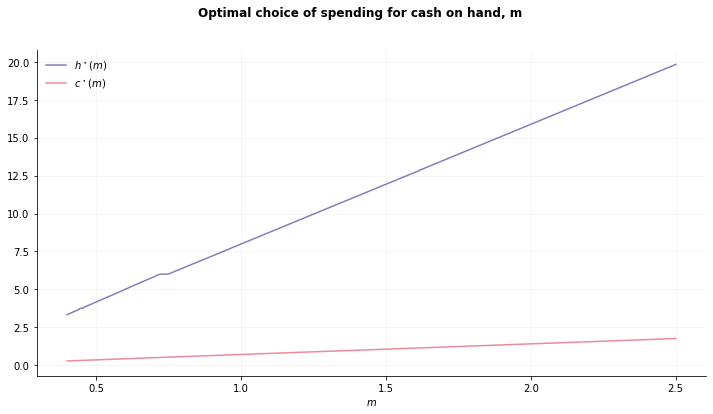

In [83]:
import matplotlib.pyplot as plt

# Create figure
fig = plt.figure(figsize = (12,6))
# Add subplot to figure
ax = fig.add_subplot(111)

# Plot data
ax.plot(m_array, h_stars, label=f'$h^\star(m)$', color = 'navy', alpha = 0.5)
ax.plot(m_array, c_stars, label=f'$c^\star(m)$', color = 'crimson', alpha = 0.5)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(f"$m$")

# Add legend (inputs are labels)
ax.legend(frameon=False)

# add grid
plt.grid(alpha = .15)

# add title
fig.suptitle(f'Optimal choice of spending for cash on hand, m', fontweight = 'bold')

# Show plot
plt.show()

# Q3 Calculating the average tax burden pr household, T/N.
For parameter values as presented in Q1, the progressive housing tax will kick in at house quality, $h\cdot \varepsilon =\bar{p} \Leftrightarrow h=\frac{\bar{p}}{\varepsilon}\Leftrightarrow h=\frac{3}{0.5}=6$. Therefore bunching, a clustering of $h$, can occurs just before the progressive tax kicks in. This can be seen by looking at the histogram of $h$.

In [84]:
import random

N = 10000
np.random.seed(1)
m_i = np.random.lognormal(-0.4,0.35, size = N)

In [85]:
print(f'For a population of {N:d} people, distribution of cash-on-hand is as defined above and model parameters as defined in par1, the tax result is:')
avg_tax_Q3, h_stars_Q3 = pyfile.taxrev(par1, m_i, N, printres = True)

For a population of 10000 people, distribution of cash-on-hand is as defined above and model parameters as defined in par1, the tax result is:
Average tax burden for the population is 0.036 mDKK, corresponding to 5.08 pct. of average cash-on-hand


In [86]:
par1

{'m': 0.5,
 'phi': 0.3,
 'epsilon': 0.5,
 'r': 0.03,
 'tau_g': 0.012,
 'tau_p': 0.004,
 'p_bar': 3}

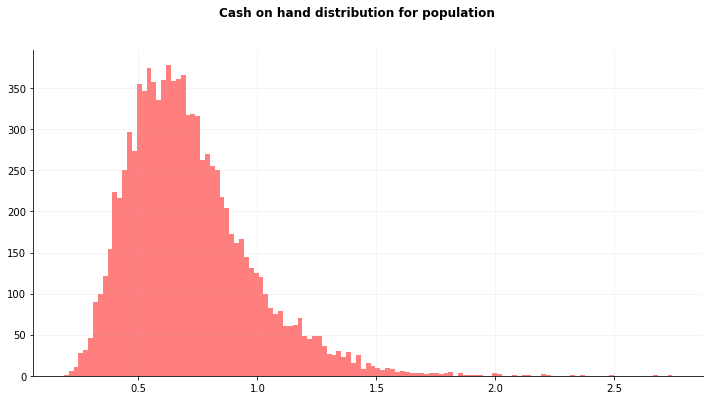

In [87]:
#Below is the Cash-on-hand distribution for the population illustrated:
fig = plt.figure(figsize = (12,6))

# Add subplot to figure
ax = fig.add_subplot(1,1,1)
ax.hist(m_i, bins=125, alpha = 0.5, color = 'r')
ax.grid(alpha = 0.15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Cash on hand distribution for population', fontweight = 'bold')
plt.show()

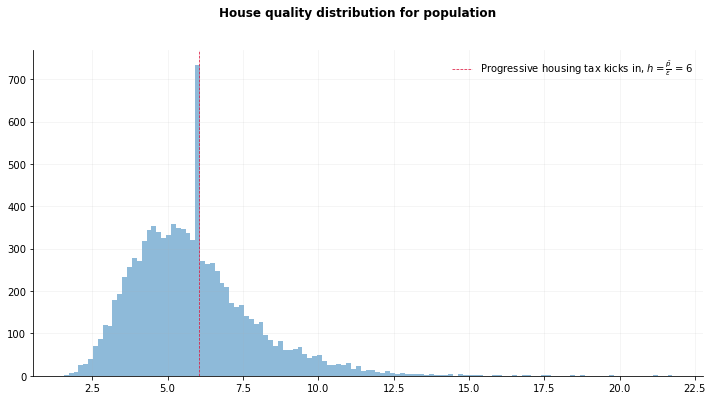

In [88]:
#Below is the house quality distrubtion for population illustrated:
fig = plt.figure(figsize = (12,6))

# Add subplot to figure
ax = fig.add_subplot(1,1,1)
ax.hist(h_stars_Q3, bins=125, alpha = 0.5)
ax.grid(alpha = 0.15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvline(6.03, color = 'crimson', linestyle = 'dashed', linewidth = .75, label = r'Progressive housing tax kicks in, $ h = \frac{\bar{p}}{\varepsilon}$ = 6')
plt.legend(frameon=False)
plt.suptitle('House quality distribution for population', fontweight = 'bold')
plt.show()

#The odd thing there should be noticed is the bunching around the house quality = 6.

# Q4 The policy maker decides to reform the tax system on housing. Calculating the average taxes as some parameters changes:
Parameters for the housing tax have changed such that, $$\epsilon = 0.8, \tau^g=0.01, \tau^p=0.009,\quad \textrm{and}\quad \bar{p}=8$$This implies a now flatter housing tax and higher progressive tax with a higher threshold.

The threshold of $h$ is now, $h\cdot\varepsilon=\bar{p}\Leftrightarrow h=\frac{\bar{p}}{\varepsilon}=\frac{8}{0.8}=10$. These changes result in that the average tax payment has increased to 45,000 DKK as calculated below.

In [89]:
par2 = {'m':0.5,
        'phi':0.3,
        'epsilon': 0.8,
        'r': 0.03,
        'tau_g': 0.01,
        'tau_p': 0.009,
        'p_bar': 8
}

In [90]:
# Calculating and storing average tax and house quality choice for new parameters
print(f'For a population of {N:d} people, distribution of cash-on-hand as defined above and model parameters as defined in par2, the tax result is:')
avg_tax_Q4, h_stars_Q4 = pyfile.taxrev(par2, m_i, N, printres = True)
# avg_tax_Q4, h_stars_Q4 = taxrev(N=N,**par2)

For a population of 10000 people, distribution of cash-on-hand as defined above and model parameters as defined in par2, the tax result is:
Average tax burden for the population is 0.045 mDKK, corresponding to 6.30 pct. of average cash-on-hand


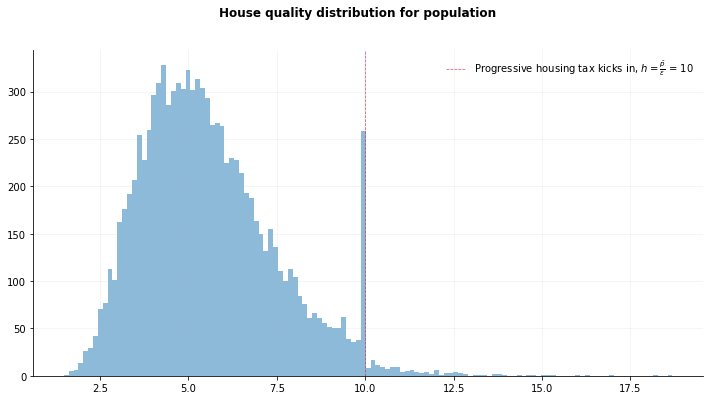

In [91]:
#Below is the house quality distrubtion for population illustrated:
fig = plt.figure(figsize = (12,6))
# Add subplot to figure
ax = fig.add_subplot(1,1,1)

ax.hist(h_stars_Q4, bins=125, alpha = 0.5)
ax.grid(alpha = 0.15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvline(10, color = 'crimson', linestyle = 'dashed', linewidth = .75, alpha = 0.75, label = r'Progressive housing tax kicks in, $ h = \frac{\bar{p}}{\varepsilon}$ = 10')
plt.legend(frameon=False)
plt.suptitle('House quality distribution for population', fontweight = 'bold')
plt.show()

#Now bunching occurs around the house quality = 10

# Q5 The policy maker wants to ensure that the average home owner does not pay more in housing taxes, while changing $\tau^g$.

In order to find the optimal value of $\tau^g$, which will offset the reform changes in Q4, we use a optimizer since this is more precise and quicker than using a loop. We create a new objective function based on our former scaler optimizer, and to find the solution we use optimize.root.

In [92]:
from scipy import optimize
guess = 0.0076
sol = optimize.root(pyfile.tax_objective_function, x0 = guess, args=(par2,avg_tax_Q3,m_i,N))
sol_tau_g = sol.x[0]
tax_diff = pyfile.tax_objective_function(sol_tau_g, par2, avg_tax_Q3, m_i, N)

In [76]:
par3 = par2.copy()
par3['tau_g'] = sol_tau_g
calc_tax = pyfile.taxrev(par3, m_i, N)[0]

print(f'Using root optimize will leave us with a tau^g value of {sol_tau_g:.8f} resulting in a average tax burden of {calc_tax:.8f} with a total difference of {tax_diff:.8f} as the target average tax burden is {avg_tax_Q3:.8f}')

Using root optimize will leave us with a tau^g value of 0.00767094 resulting in a average tax burden of 0.03632680 with a total difference of 0.00000000 as the target average tax burden is 0.03632680


We have also found the off-setting solution of $\tau_g$ using a loop. 

The code below iterates over different levels of $\tau^g$ and estimates the average tax burden. We iterate over $\tau^g$-values in the interval $(0,0.01)$ because we want to lower the average tax burden from 45,036.3 DKK to 36,326.8 DKK, while changing $\tau^g$ and keeping other model parameters fixed as in Q4.

As each iteration is calculated for a population of 10,000, the loop takes a while. We know, somewhat precise, where the $\tau^g$-value is by doing the below iterations for 1,000 $\tau^g$-values in the above-mentioned interval.

If you want to arrive at the solution quicker, while still getting a precise result, use fewer iterations **and** a smaller interval of $\tau^g$ as suggested below in the two first hashed lines. This is sort of a shortcut as we already know, somewhat precise, which $\tau^g$ solves our problem.

However, this loop solution leads to a less precise value of $\tau_g$ with a tax difference of around 12 DKK per household. 

In [79]:
import time

#N_tau_g = 200
#tau_gs = np.linspace(0.007, 0.008, N_tau_g)
N_tau_g = 1000
tau_gs = np.linspace(0, 0.01, N_tau_g)
tax_diff = np.inf
tau_g_Q5 = 1


starttime = time.time()
for i, v in enumerate(tau_gs):
    idx = i+1
    # Storing the original tau_g-value
    if i == 0:
        tau_g_save = par2['tau_g']
    
    # Updating tau_g
    par2['tau_g'] = v

    # Calculating difference
    new_tax = pyfile.taxrev(par2, m_i, N)[0]
    tax_d = avg_tax_Q3 - new_tax
    
    # if this tau_g solution is better than previously, update it
    if abs(tax_d) < tax_diff:
        tau_g_Q5 = v
        avg_tax_Q5 = new_tax
        tax_diff = tax_d

    # Restoring old tau_g value in the dictionary
    if i == len(tau_gs)-1:
        par2['tau_g'] = tau_g_save
    
    # Printing progress with an increment of 5
    if idx % 5 == 0:
        print(f'{idx} of {len(tau_gs)}')

endtime = time.time()
time_elapsed = endtime - starttime

print(f'For {N_tau_g} iterations, taking {time_elapsed} seconds, the flat housing tax is estimated as = {tau_g_Q5:.7f} where the average tax burden is {avg_tax_Q5:.7f} mDKK with old tax burden being = {avg_tax_Q3:.7f} mDKK, the difference being {tax_diff:.7f} mDKK')

5 of 200
10 of 200
15 of 200
20 of 200
25 of 200
30 of 200
35 of 200
40 of 200
45 of 200
50 of 200
55 of 200
60 of 200
65 of 200
70 of 200
75 of 200
80 of 200
85 of 200
90 of 200
95 of 200
100 of 200
105 of 200
110 of 200
115 of 200
120 of 200
125 of 200
130 of 200
135 of 200
140 of 200
145 of 200
150 of 200
155 of 200
160 of 200
165 of 200
170 of 200
175 of 200
180 of 200
185 of 200
190 of 200
195 of 200
200 of 200
For 200 iterations, taking 464.63683915138245 seconds, the flat housing tax is estimated as = 0.0076734 where the average tax burden is 0.0363363 mDKK with old tax burden being = 0.0363268 mDKK, the difference being -0.0000095 mDKK
